In [7]:
from typing import Union
from random import randint

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister
from numpy import pi
# uncomment to check version
# import qiskit
# print(qiskit.__version__)

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-12-13 19:44:26,953: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
# Number of shots
shots = 1024

# Choose a device
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

n = 6  # Set this to double the secret's string size
# Run on quantum computer
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
#                                    not x.configuration().simulator and x.status().operational==True))

# OR

# run on simulating Backend
backend = Aer.get_backend('qasm_simulator')

backend

QasmSimulator(
backend_name='qasm_simulator', provider=AerProvider())

In [11]:
class SimonBlackbox:
    def __init__(self, secret: str):
        """The Simon Blackbox requires to have a secret string to
        xor with the input

        @param {String} secret
        @returns {SimonBlackbox}
        """
        self.secret = secret[::-1]  # Reversed cause the IBM Computers write the qbits in reverse order
    
    def run(self, circ: QuantumCircuit, qreg: QuantumRegister, areg: AncillaRegister):
        """run() executes the blackbox changing the state
        to |x> |f(x)>

        @param {QuantumCircuit}
        @param {QuantumRegister} qreg
        @param {AncillaRegister} areg
        """
        # The length of the registers must be the same as the
        # length of the secret
        if len(qreg) != len(self.secret):
            raise Exception(f"The length of the qbit register ({len(qreg)}) didn't match the length of the secret ({len(self.secret)}).")
        # First step: Copy the input to the output
        for i, x in enumerate(qreg):
            circ.cx(x, areg[i])
        # Second step: Find the first occurence of a '1' in the secret
        first_one: int = self.secret.find('1')
        if first_one < 0:
            # there was no 1, the string of all 0's
            # returns exactly the output
            return
        # Third step: iterate through all the ancilla qubits
        # and CNOT Controlling the bit in the input at the same
        # index where the first '1' was found in the secret and
        # NOT all the ancilla bits at the same index of any '1'
        # in the secret
        for i, bit_ancilla in enumerate(areg):
            if self.secret[i] == '1':
                circ.cx(qreg[first_one], bit_ancilla)
    
    def sdota(self, data):
        """Takes the data and returns the dot multiplications
        with the secret
        """
        accu = 0
        real_secret = self.secret[::-1]  # It was reversed before
        for i in range(len(self.secret)):
            accu += int(real_secret[i]) * int(data[i])
        return (accu % 2)

In [16]:
# Initialize Circuit
quantum_reg = QuantumRegister(n/2, "q")
ancilla_reg = AncillaRegister(n/2, "a")
classical_reg = ClassicalRegister(n/2, "c")

circ = QuantumCircuit(quantum_reg, ancilla_reg, classical_reg, name="Home Assignment")

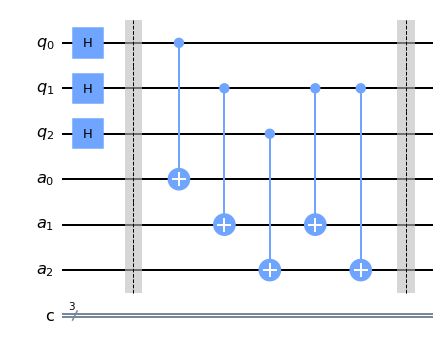

In [17]:
blackbox = SimonBlackbox('110')

for qbit in quantum_reg:
    circ.h(qbit)

circ.barrier()
blackbox.run(circ, quantum_reg, ancilla_reg)
circ.barrier()

circ.draw(output='mpl')

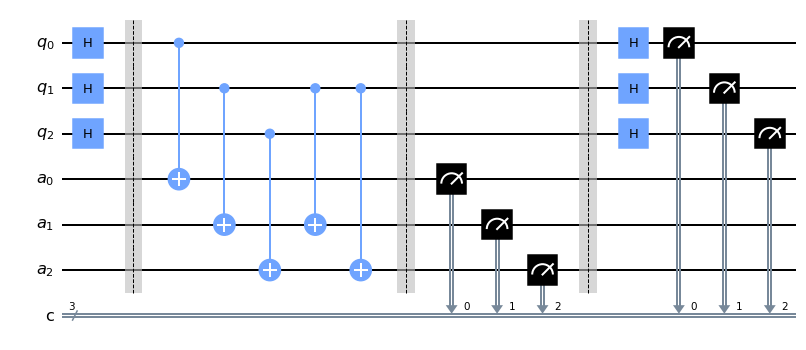

In [18]:
for index, qbit in enumerate(quantum_reg):
    circ.h(qbit)
    circ.measure(qbit, classical_reg[index])

circ.draw(output='mpl')

Job Status: job has successfully run


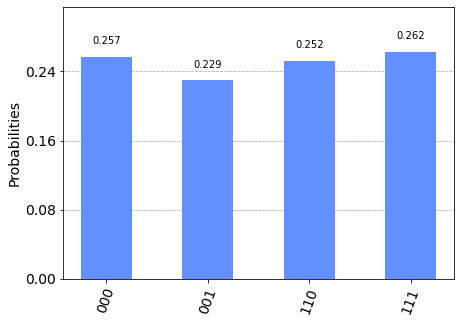

In [19]:
job = execute(circ, backend=backend, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job, interval = 2)

result = job.result()

# Returns counts
data = result.get_counts(circ)

# Draw an Histogram
plot_histogram(data)

In [63]:
dot_results: list = []

x: str
for x in data:
    dot_results.append(blackbox.sdota(x))
    print(f"secret.{x} = {blackbox.sdota(x)} (mod 2)")

secret.000 = 0 (mod 2)
secret.001 = 0 (mod 2)
secret.100 = 0 (mod 2)
secret.101 = 0 (mod 2)
